# Clustering in two dimensions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from functions import gen_domains2D, plot_domains2D, confidence_ellipse

This is an introduction to some of the considerations needed for data clustering in higher dimensions and an example of using Gaussian mixture models to predict the best cluster for unknown data.

## The advantages of higher dimensions
* The example below shows a sample of three materials with two measurements (which could be _e.g._ surface potential and tapping phase)
* Comparing the scatter plot to the histograms shows the advantage of higher dimensions:
  * Clusters that are overlapping in 1D may be distinct in 2D or higher
  * Distances in 1D are given by $x-x_0$ but in 2D are given by $\sqrt{(x-x_0)^2 + (y-y_0)^2}$ (and so on for higher dimensions)

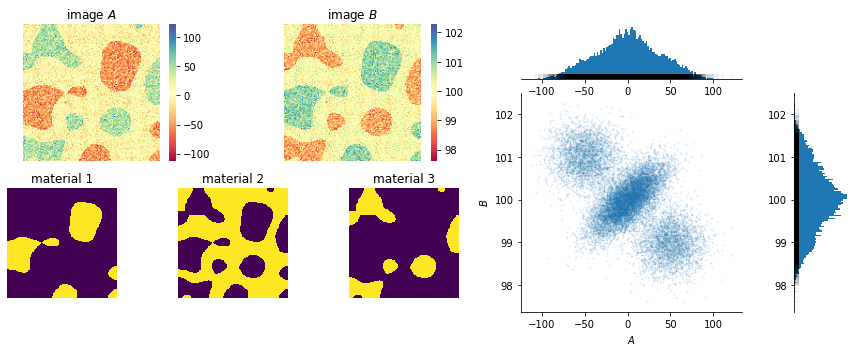

In [2]:
images, materials = gen_domains2D(
    populations=(1, 3, 1),
    means=((-50, 101), (0, 100), (50, 99)),
    stds=((10, 1/5), (10, 1/5), (10, 1/5)),
    pearsons=(0, 0.4, 0)
);
plot_domains2D(images, materials);

## Normalisation
* Clustering looks at distances between points to judge their similarity
* But often, different observations have different units and variances so it's not fair to equate them
* As an example, if I plot the scatter data from above, but use an equal scaling, the $A$ parameter completely dominates all the point-to-point distances


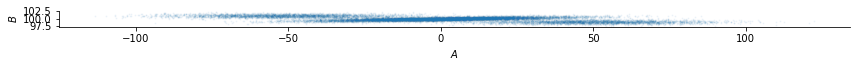

In [3]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(*images.reshape(2, -1), alpha=0.05, s=1)
ax.set(
    xlabel='$A$',
    ylabel='$B$',
    aspect='equal'
)
for side in ('top', 'right'):
    ax.spines[side].set_visible(False)
fig.tight_layout()

* We don't want to assume that either parameter is more important so we use Mahalanobis normalisation
* Each dimension is normalised to its mean, $\mu$, and standard deviation, $\sigma$, as $\frac{data - \mu(data)}{\sigma(data)}$
* This means every observation has unit variance and zero mean
* It also means the data is made dimensionless, which removes complications of different units
* The scatter plot of Mahalanobis normalised data below shows that neither $A$ nor $B$ is given unfair precendence

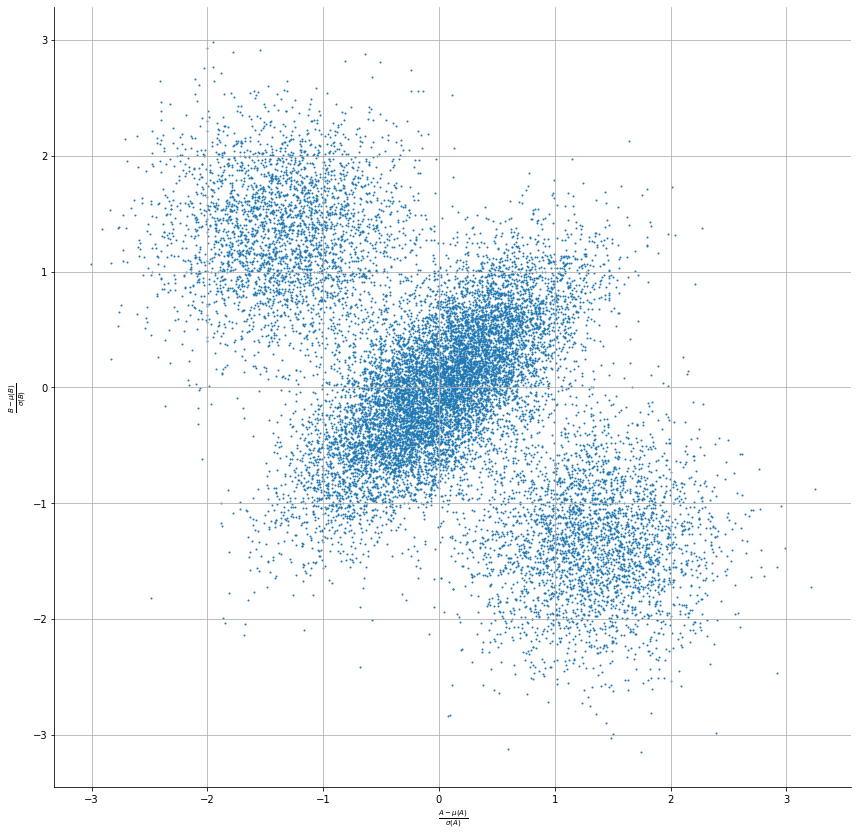

In [4]:
mahalanobis = (
    (images - images.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(*mahalanobis.reshape(2, -1), s=1)
ax.set(
    xlabel=r'$\frac{A-{\mu}(A)}{{\sigma}(A)}$',
    ylabel=r'$\frac{B-{\mu}(B)}{{\sigma}(B)}$',
    aspect='equal'
)
ax.grid()
for side in ('top', 'right'):
    ax.spines[side].set_visible(False)
fig.tight_layout()

## Using clustering to classify new data
* One of the main advantages of data clustering is that it can be used to automatically identify new data as belonging to a particular cluster
* To show this I'm splitting the image above into two halves, top and bottom
* I'll train the clustering on the top, and test it on the bottom

In [5]:
images_top = images[:, :64]
materials_top = [mat[:64] for mat in materials]
images_bottom = images[:, 64:]
materials_bottom = [mat[64:] for mat in materials]

### Training phase
* I start by normalising the data from the top half of the image
* This is displayed below

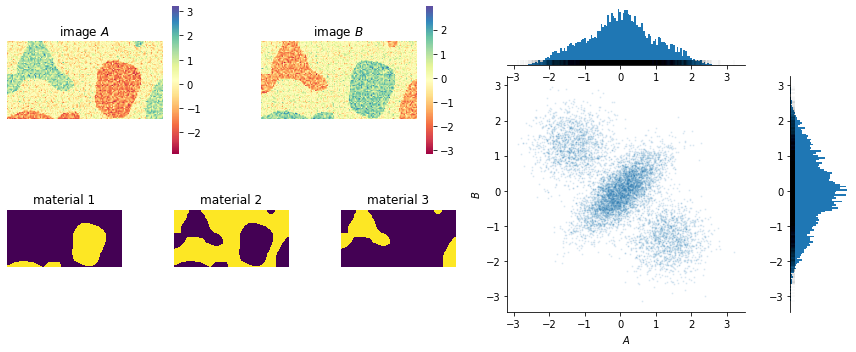

In [6]:
norm_top = (
    (images_top - images_top.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images_top.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)
plot_domains2D(norm_top, materials_top);

* It has three materials and so should be fit best by three clusters
* I train a three-component Gaussian mixture model (GMM) on the data then calculate the probability each point belongs to a particular cluster

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3).fit(norm_top.reshape(2, -1).T)
labels_top = gmm.predict(norm_top.reshape(2, -1).T)
probs_top = gmm.predict_proba(norm_top.reshape(2, -1).T)

* The scatter plot below shows the three identified clusters (ellipses show $1\sigma$ away from the mean position)
* The probability for each point being in the cluster is shown by the images

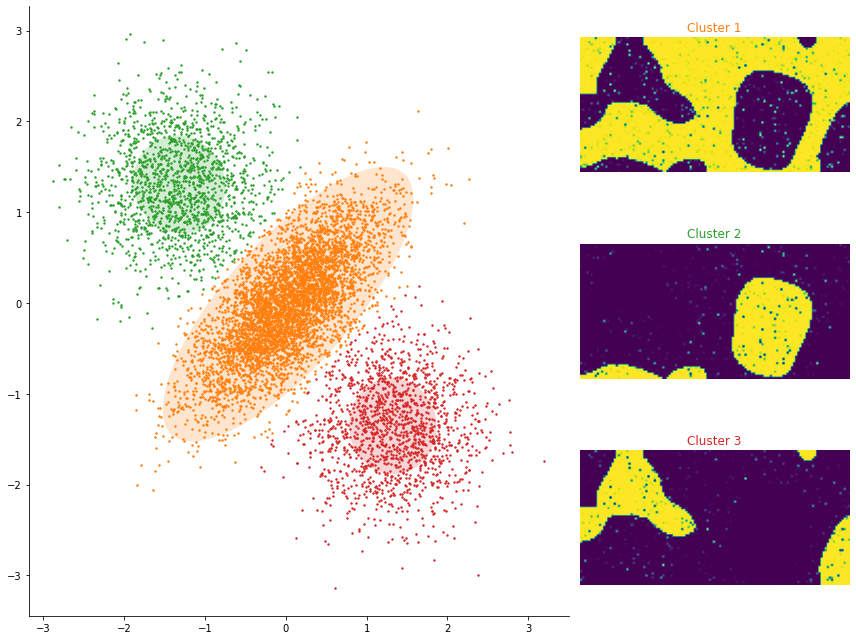

In [8]:
fig = plt.figure(figsize=(12, 9))
gs = plt.GridSpec(figure=fig, nrows=3, ncols=2, width_ratios=(2, 1))
scatter_ax = fig.add_subplot(gs[:, 0])
cluster_axes = [fig.add_subplot(gs[i, -1]) for i in range(3)]
for i in range(3):
    c = f'C{i+1}'
    scatter_ax.scatter(*norm_top.reshape(2, -1)[:, labels_top==i], c=c, s=2)
    confidence_ellipse(scatter_ax, gmm.means_[i], gmm.covariances_[i], fc=c, ls='--', lw=2, alpha=0.2)
    cluster_axes[i].imshow(probs_top[:, i].reshape(images_top[0].shape))
    cluster_axes[i].set_title(f'Cluster {i+1}', c=c)
    cluster_axes[i].set_axis_off()
for side in ('top', 'right'):
    scatter_ax.spines[side].set_visible(False)
fig.tight_layout()

### New data
* We now want to use the clusters found above from the top of the image, to assess the materials in the bottom of the image
* To do this we need to apply the same normalisation as we did for the training data:
  * For the training data we used Mahalanobis normalisation $\frac{training - \mu(training)}{\sigma(training)}$
  * For fairness we can't simply Mahalanobis normalise the testing data (it may have a different $\mu$ and $\sigma$)
  * We need to do $\frac{new data - \mu(training)}{\sigma(training)}$
* The appropriately normalised new data from the bottom half of the image is shown here

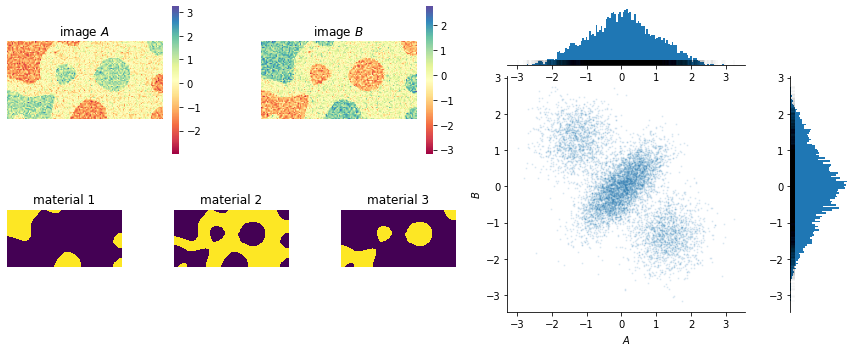

In [9]:
norm_bottom = (
    (images_bottom - images_top.mean(axis=(1, 2))[:, np.newaxis, np.newaxis])
    / images_top.std(axis=(1, 2))[:, np.newaxis, np.newaxis]
)
plot_domains2D(norm_bottom, materials_bottom);

* We still have the means and covariances of our Gaussian clusters found from the training data
* We can use these to predict the likelihood that a point from the new data set belongs to each cluster

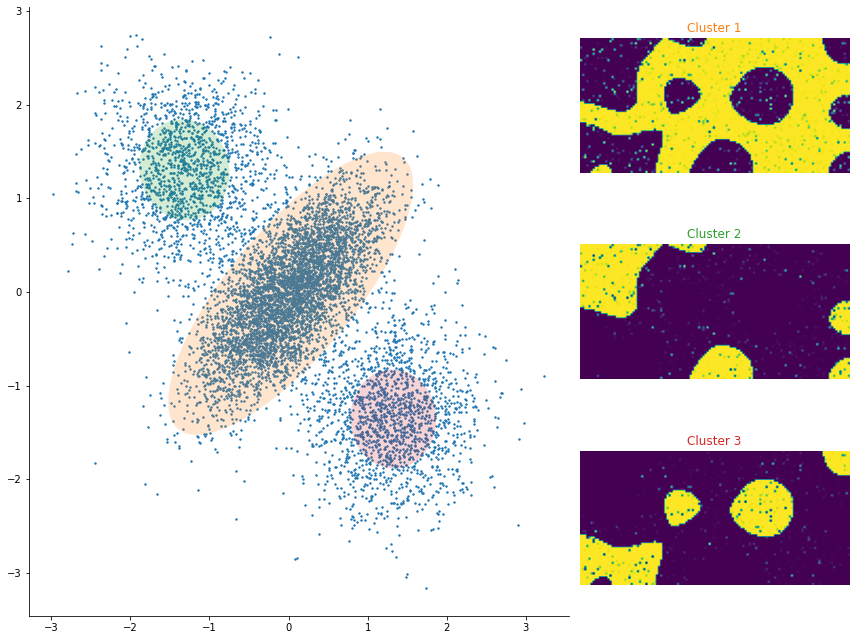

In [10]:
probs_bottom = gmm.predict_proba(norm_bottom.reshape(2, -1).T)
fig = plt.figure(figsize=(12, 9))
gs = plt.GridSpec(figure=fig, nrows=3, ncols=2, width_ratios=(2, 1))
scatter_ax = fig.add_subplot(gs[:, 0])
cluster_axes = [fig.add_subplot(gs[i, -1]) for i in range(3)]
scatter_ax.scatter(*norm_bottom.reshape(2, -1), c='C0', s=2)
for i in range(3):
    c = f'C{i+1}'
    confidence_ellipse(scatter_ax, gmm.means_[i], gmm.covariances_[i], fc=c, ls='--', lw=2, alpha=0.2)
    cluster_axes[i].imshow(probs_bottom[:, i].reshape(images_bottom[0].shape))
    cluster_axes[i].set_title(f'Cluster {i+1}', c=c)
    cluster_axes[i].set_axis_off()
for side in ('top', 'right'):
    scatter_ax.spines[side].set_visible(False)
fig.tight_layout()